In [ ]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
from jcm.model import SpeedyModel
from jcm.params import Parameters

def make_ones_dinosaur_StateWithTime_object(state, choose_sim_time = jnp.float32(1.0)):
    return jtu.tree_map(lambda x: jnp.ones_like(x), state)

def make_zeros_dinosaur_StateWithTime_object(state, choose_sim_time = jnp.float32(0.0)):
    zero_state = jtu.tree_map(lambda x: jnp.zeros_like(x), state)
    # zero_state.temperature_variation = zero_state.temperature_variation.at[-1, 10:25, 10:25].set(1.0)
    # zero_state.temperature_variation = zero_state.temperature_variation.at[-1, 15:20, 15:20].add(1.0)
    return zero_state
    
def make_zeros_parameters_object(params):
    def make_tangent(x):
        if jnp.issubdtype(jnp.result_type(x), jnp.bool_):
            return np.zeros((), dtype=jax.dtypes.float0)  # Zero tangent for bools
        elif jnp.issubdtype(jnp.result_type(x), jnp.integer):
            return np.zeros((), dtype=jax.dtypes.float0)  # Zero tangent for ints
        else:
            return jnp.zeros_like(x)  # Normal tangent for numerical types
    return jtu.tree_map(lambda x: make_tangent(x), params)

def make_ones_prediction_object(predictions):
    return jtu.tree_map(lambda x: jnp.ones_like(x), predictions)

def make_zeros_prediction_object(predictions):
    return jtu.tree_map(lambda x: jnp.zeros_like(x), predictions)

In [ ]:
jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", False) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", True) # some physics fields might be nan
model = SpeedyModel(
    time_step=30,
    save_interval=2,
    total_time=6,
    layers=8,
    boundary_file='/home/jvm/su24/jax-gcm/jcm/data/bc/t30/clim/boundaries_daily.nc'
)
state = model.get_initial_state()
params = Parameters.default()

In [ ]:
zero_state, zero_params = make_zeros_dinosaur_StateWithTime_object(state), make_zeros_parameters_object(params)
zero_params.surface_flux.cds = jnp.array(1.)

tangent = (zero_state, zero_params)
y, jvp_at_x = jax.jvp(model.unroll, (state, params), tangent)

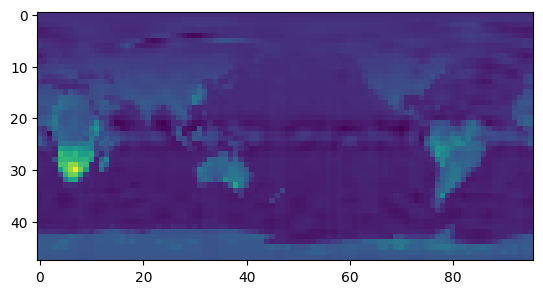

In [6]:
import matplotlib.pyplot as plt
plt.imshow(jvp_at_x[1]['physics'].longwave_rad.asdict()['ftop'][1].T[::-1])

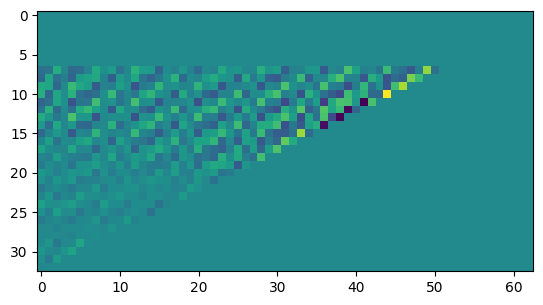

In [11]:
plt.imshow(jvp_at_x[1]['dynamics'].temperature_variation[2][7].T[::-1])

In [12]:
print(y[1]['physics'].shortwave_rad.asdict().keys())
print(jvp_at_x[1]['physics'].surface_flux.asdict().keys())

dict_keys(['qcloud', 'fsol', 'rsds', 'ssr', 'ozone', 'ozupp', 'zenit', 'stratz', 'gse', 'icltop', 'cloudc', 'cloudstr', 'ftop', 'dfabs'])
dict_keys(['ustr', 'vstr', 'shf', 'evap', 'slru', 'hfluxn', 'tsfc', 'tskin', 'u0', 'v0', 't0'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-998211.25..3932212.0].


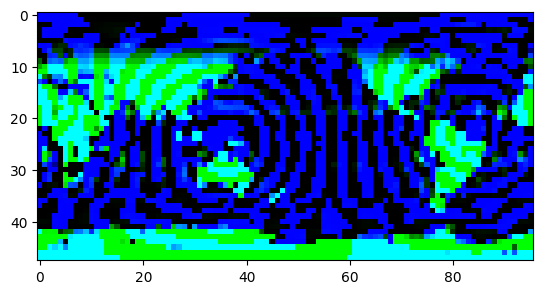

In [13]:
plt.imshow(jvp_at_x[1]['physics'].surface_flux.evap.T[7][::-1])

In [5]:
# (final_state, predictions), vjp_fn = jax.vjp(model.unroll, state)

In [ ]:
# cotangent = (
#     make_zeros_dinosaur_StateWithTime_object(final_state),
#     make_zeros_prediction_object(predictions)
# )
# grad_state = vjp_fn(cotangent)

In [15]:
grad_ds = model.predictions_to_xarray(jvp_at_x[1])
print(f"dataset size: {grad_ds.nbytes/1e6:.1f}MB")

dataset size: 11.8MB


/home/jvm/su24/jax-gcm/jcm/model.py:303: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  pred_ds['time'] = (self.start_date.delta.days + pred_ds.time).astype('datetime64[D]')


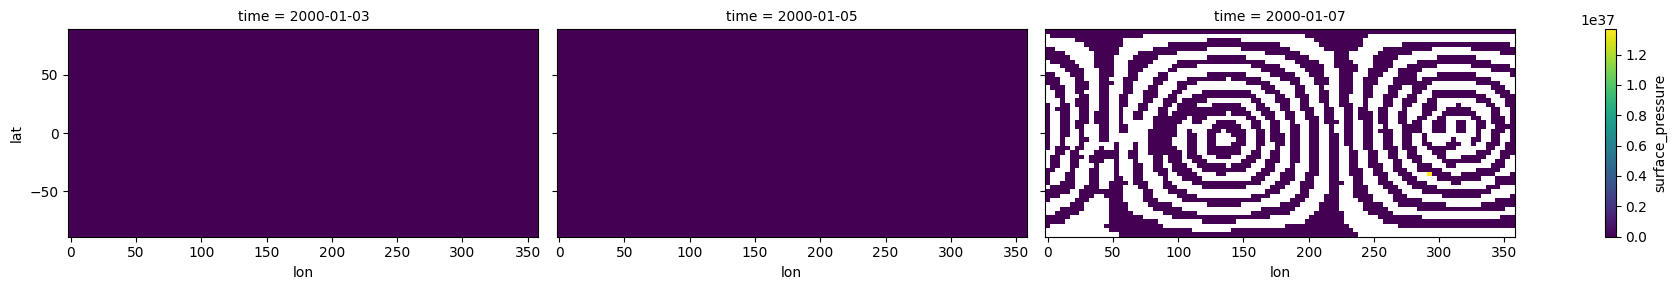

In [16]:
grad_ds['surface_pressure'].plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2);

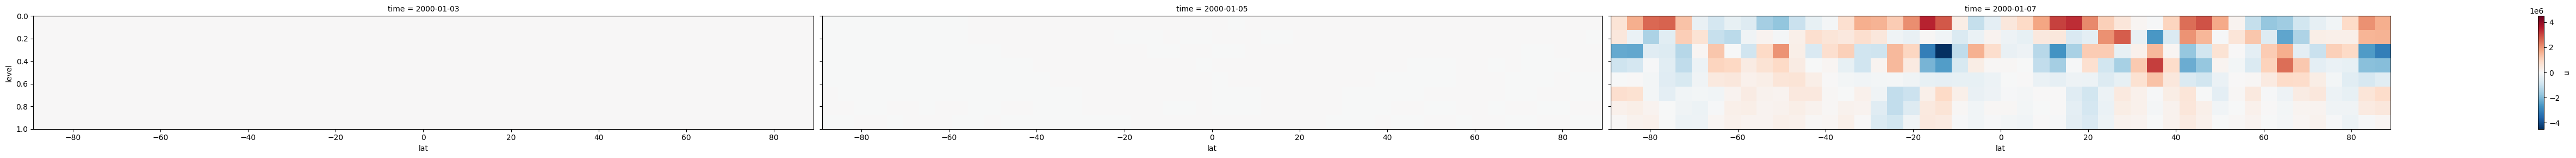

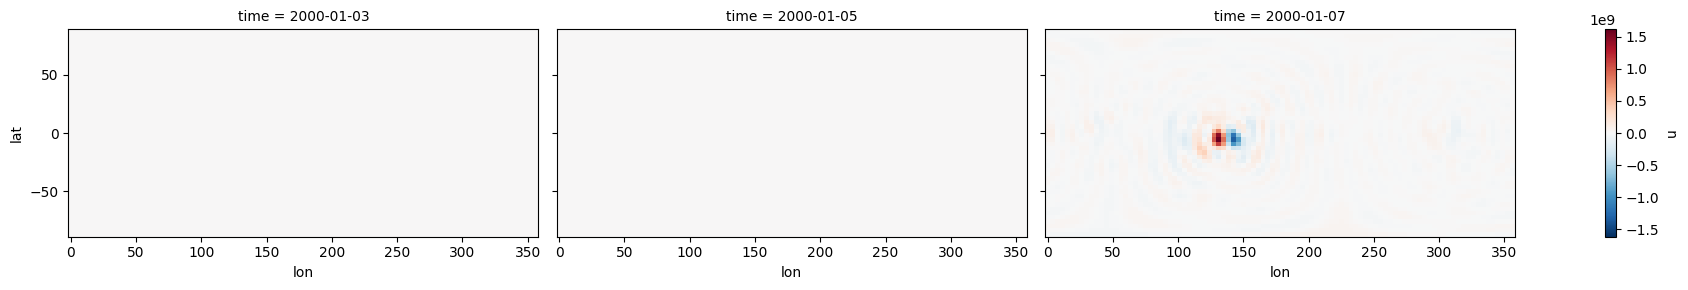

In [17]:
grad_ds['u'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=3, aspect=6, yincrease=False);
grad_ds['u'].isel(level=-1).plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2);

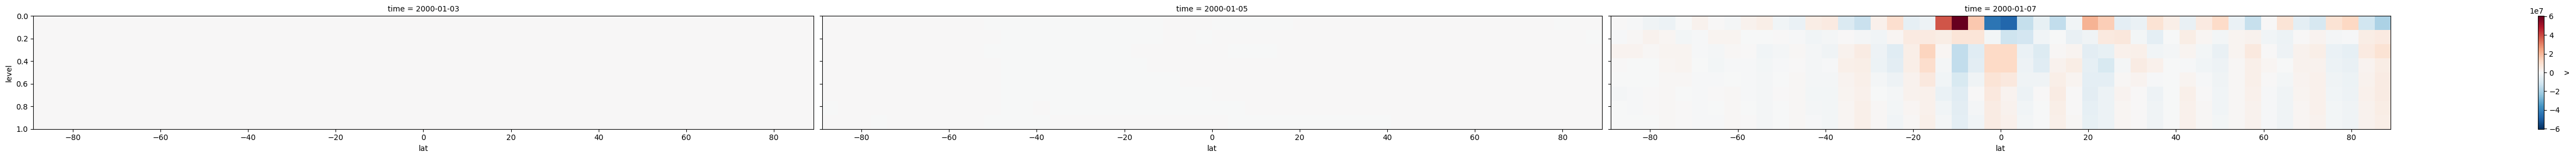

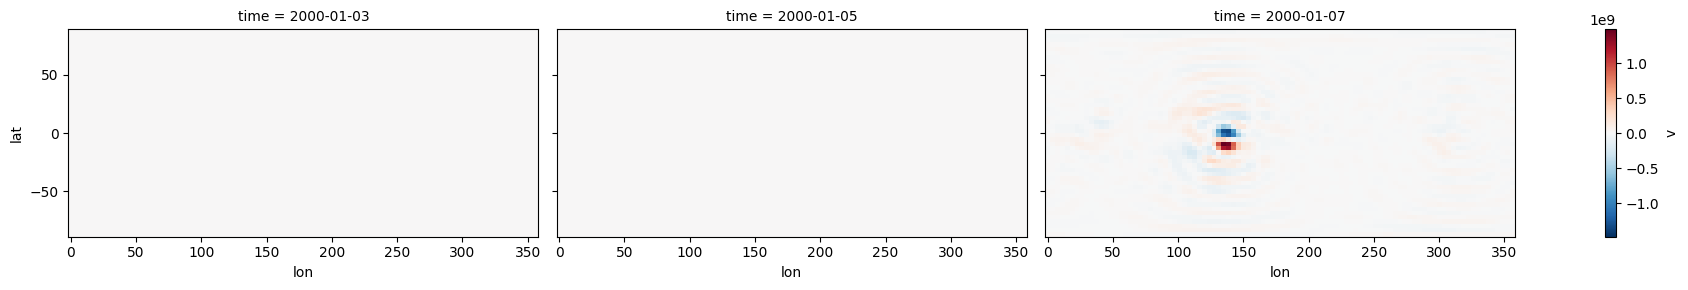

In [18]:
grad_ds['v'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=3, aspect=6, yincrease=False);
grad_ds['v'].isel(level=-1).plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2);

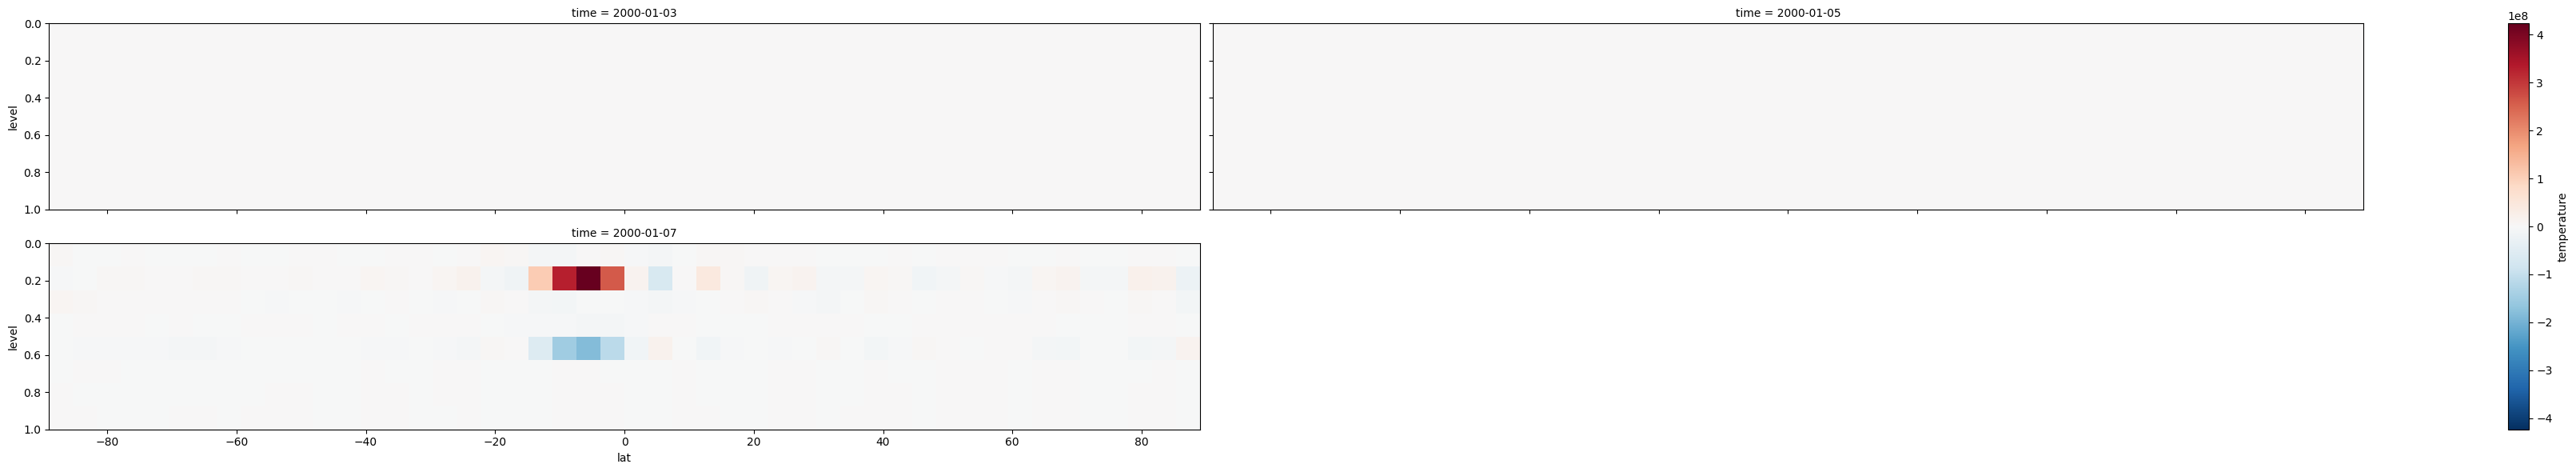

In [19]:
grad_ds['temperature'].mean('lon').plot(x='lat', y='level', col='time', col_wrap=2, aspect=6, yincrease=False);

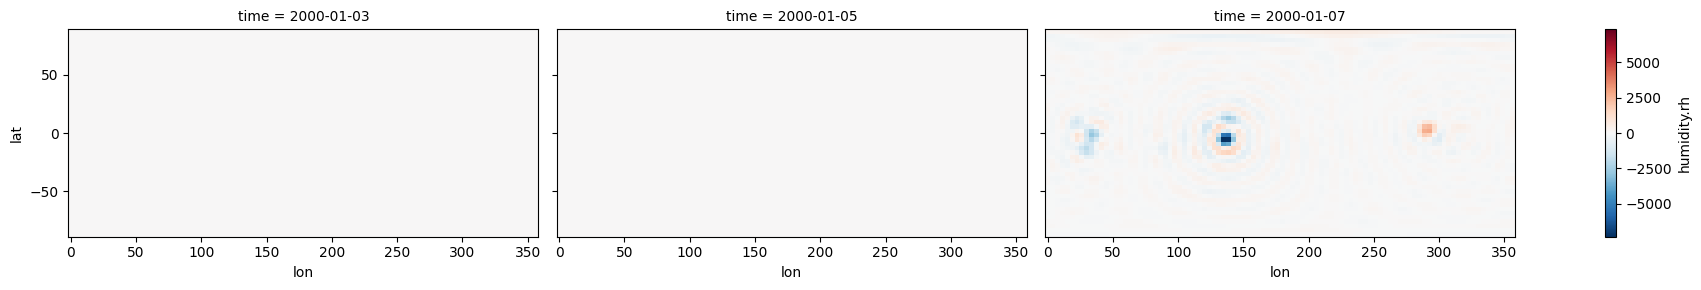

In [35]:
grad_ds['humidity.rh'].isel(level=7).plot(x='lon', y='lat', col='time', col_wrap=3, aspect=2);

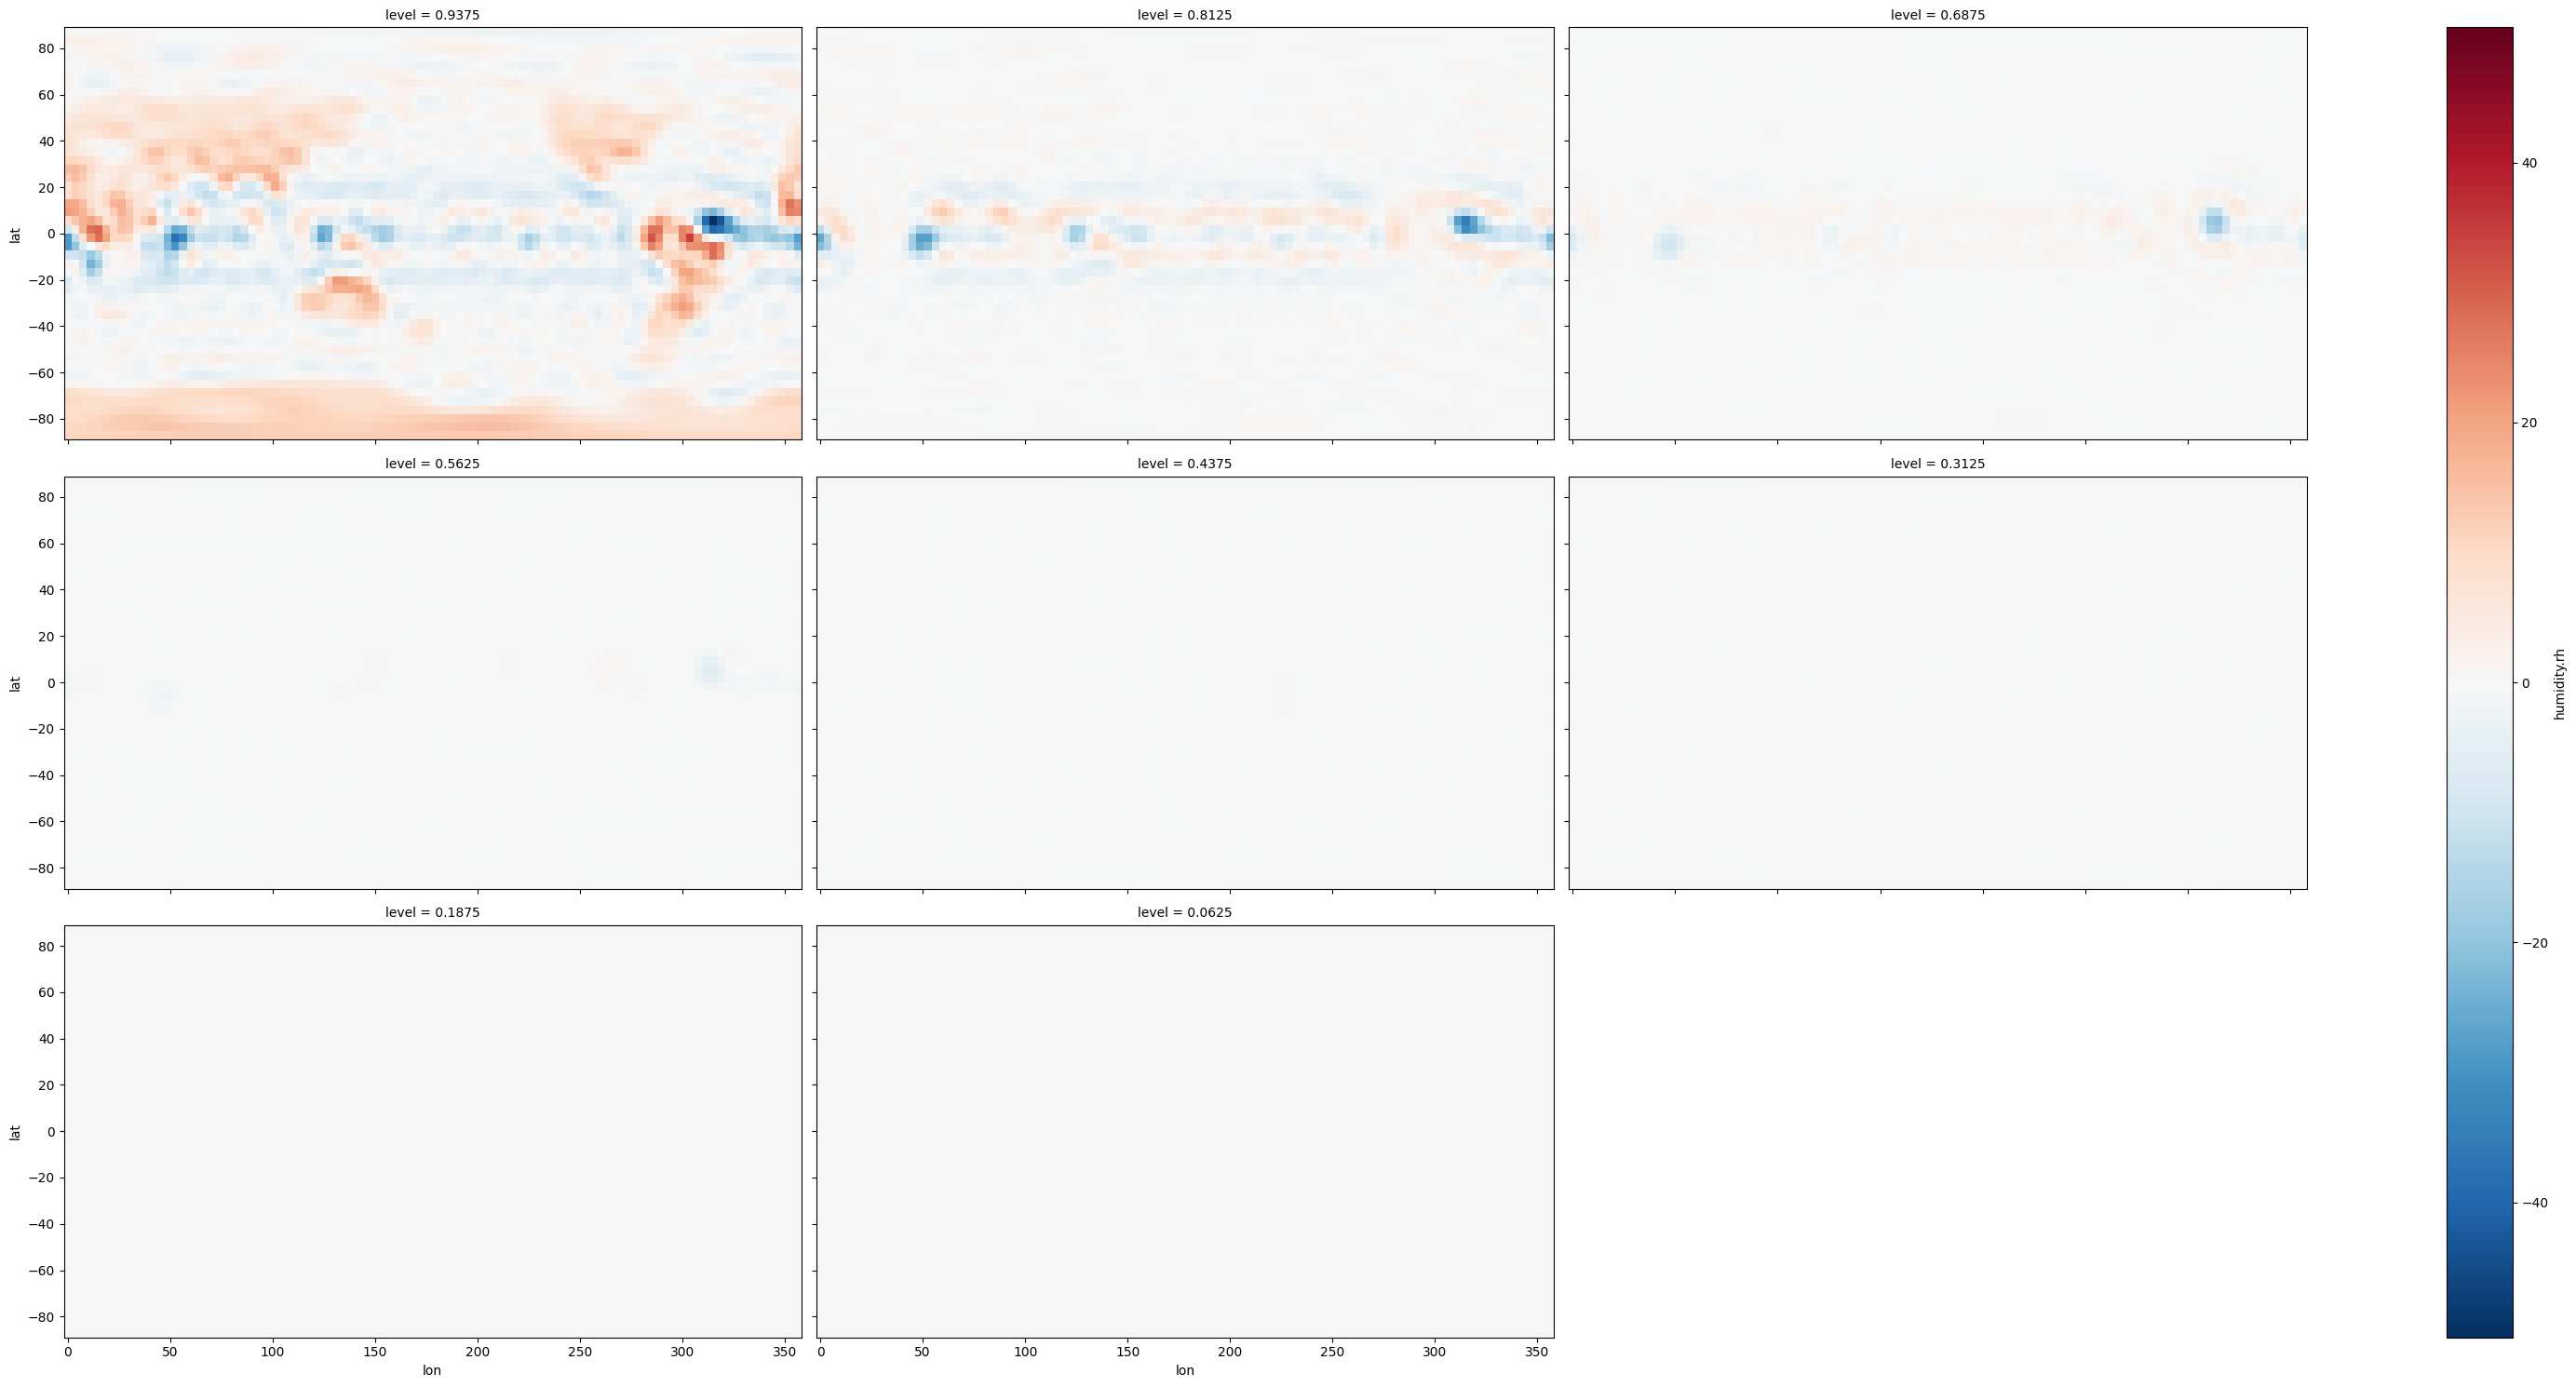

In [ ]:
grad_ds['humidity.rh'].isel(time=1).plot(x='lon', y='lat', size=5, aspect=2, col='level', col_wrap=3);

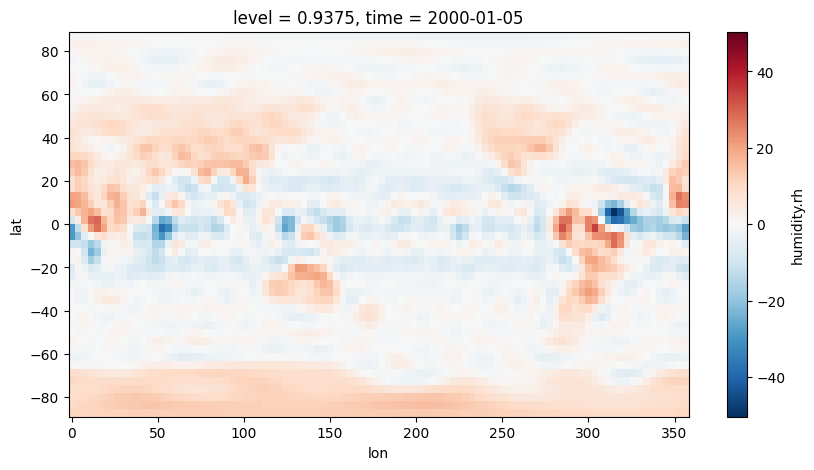

In [44]:
grad_ds['humidity.rh'].isel(time=1, level=0).plot(x='lon', y='lat', size=5, aspect=2)

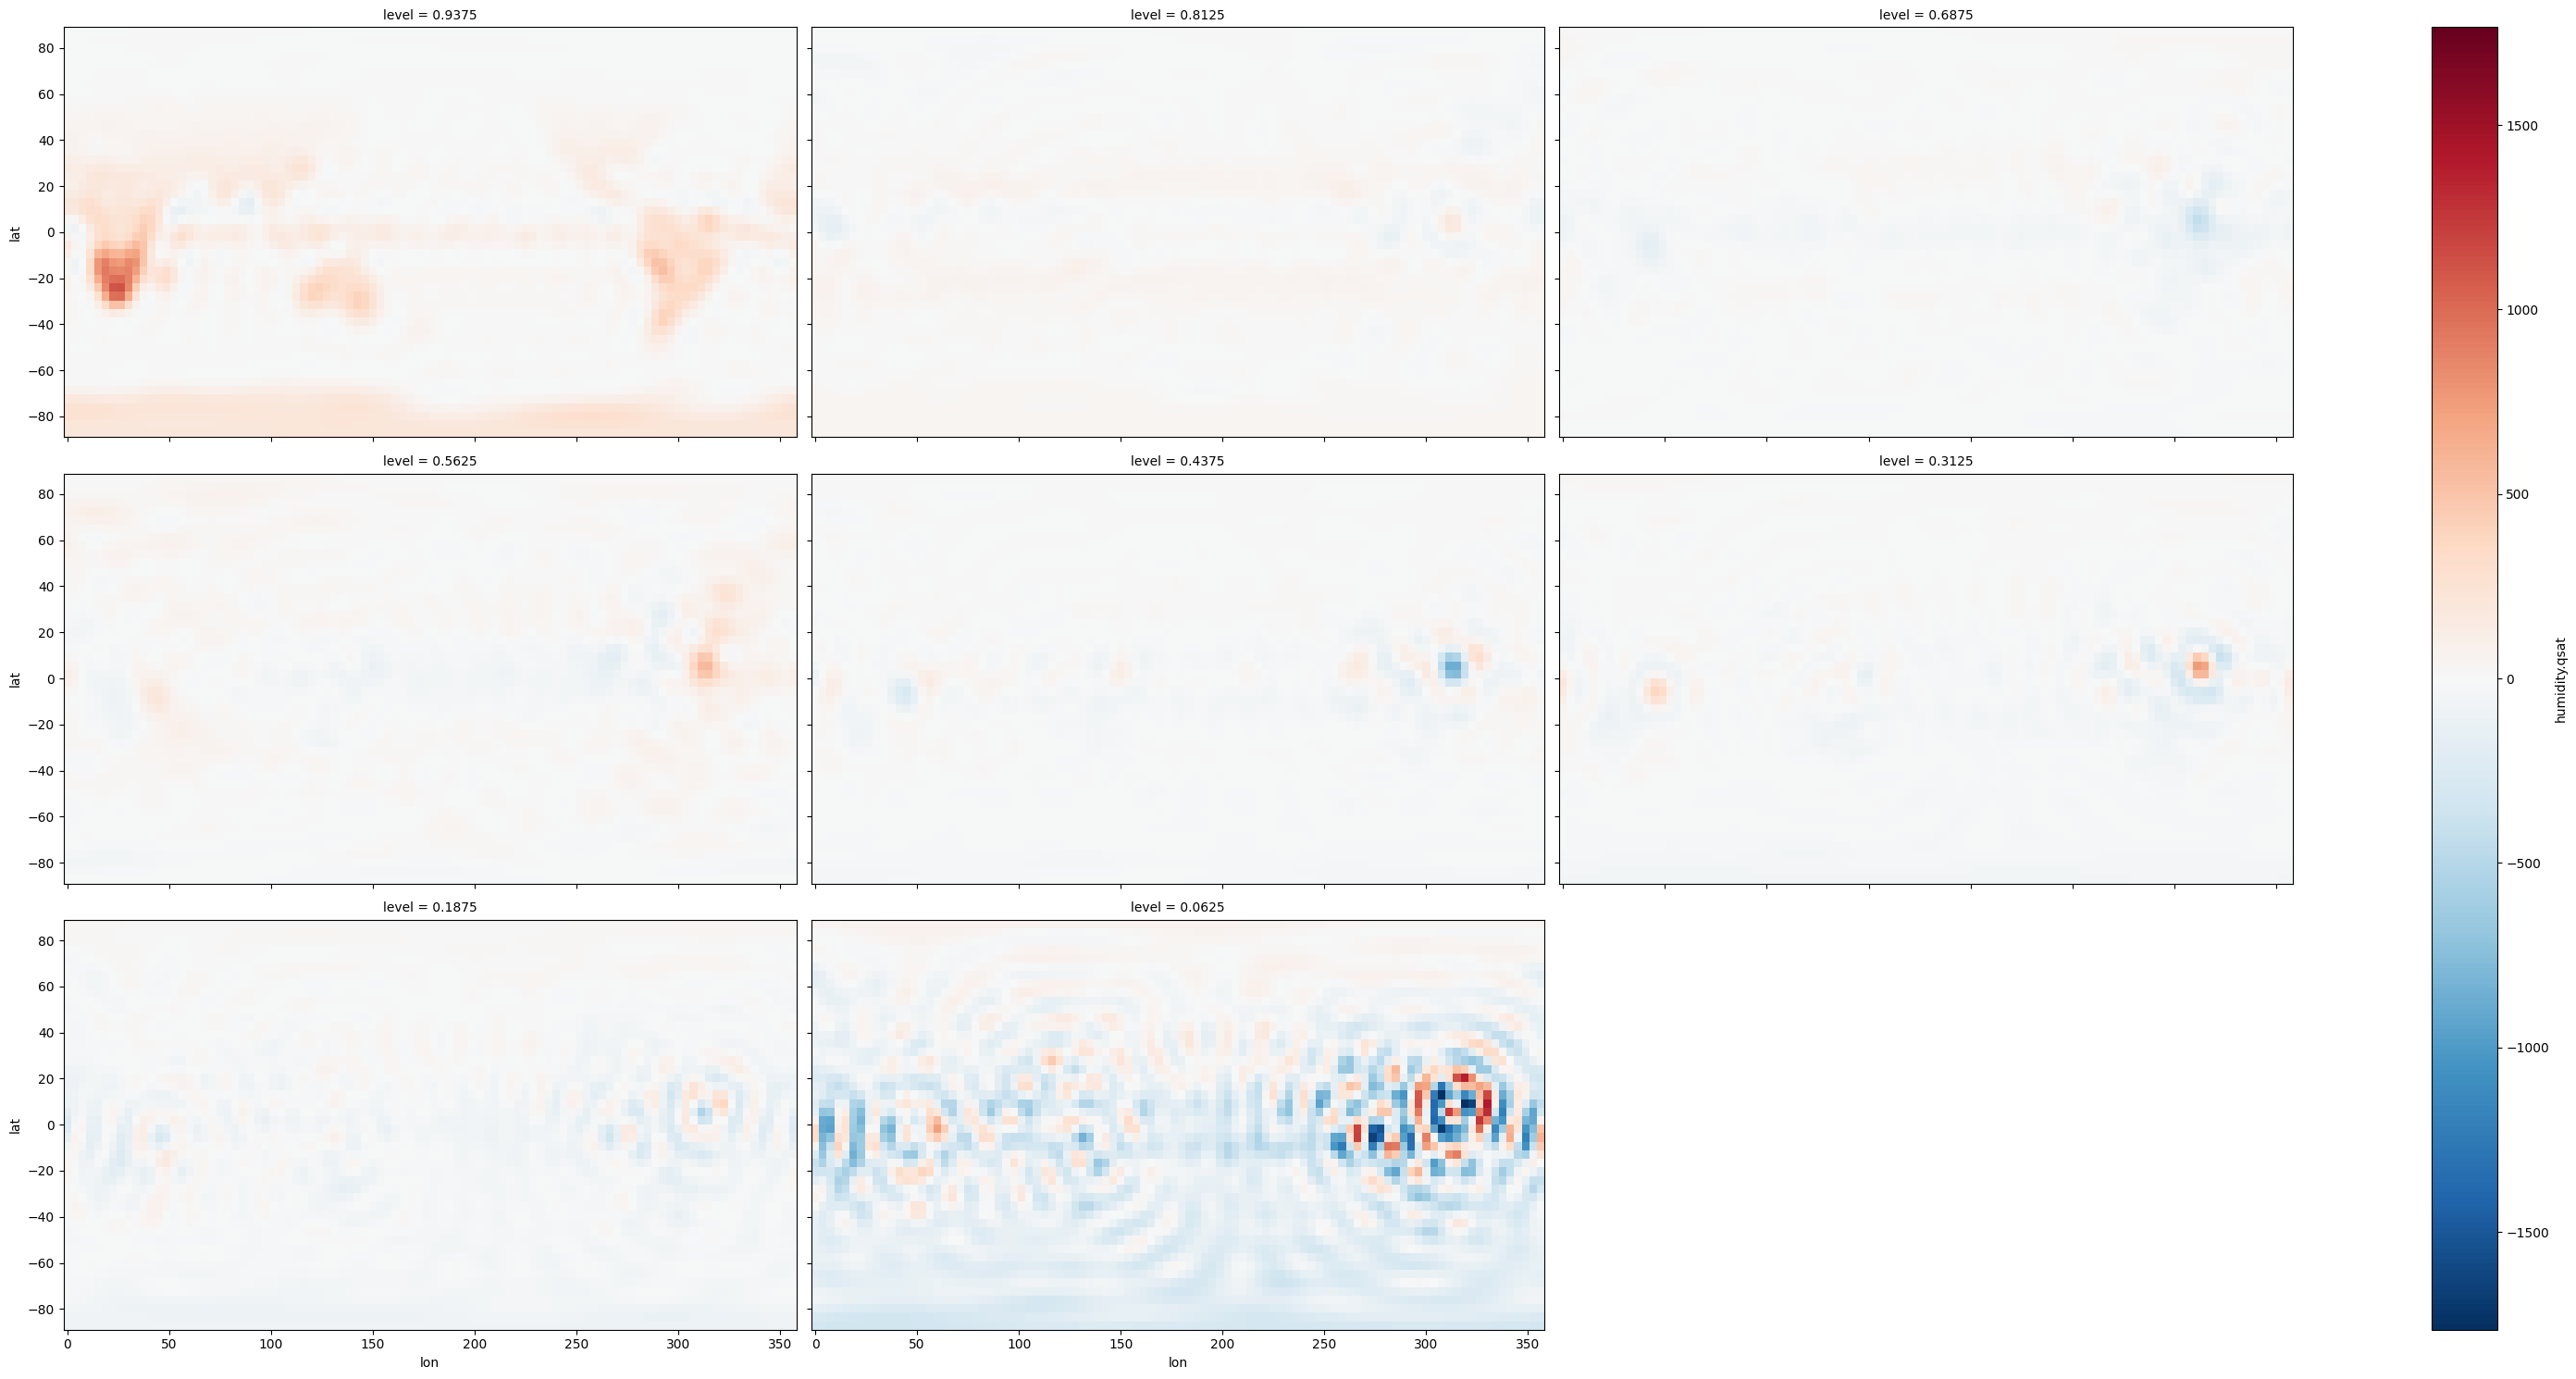

In [45]:
grad_ds['humidity.qsat'].isel(time=1).plot(x='lon', y='lat', size=5, aspect=2, col='level', col_wrap=3);